In [136]:
from fears.population import Population
from fears.experiment import Experiment
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fears.utils import stats, plotter, fitness
import scipy.stats as spstats
import os
import matplotlib.lines as mlines


np.random.seed(2024)

init_counts = np.zeros(16)
init_counts[0] = 10**5

options = {
    'mut_rate':10**-8,
    'fitness_data':'from_file',
    'use_carrying_cap':True,
    'carrying_cap':10**9,
    'dwell':True,
    'dwell_time':24*4,
    'death_model':'pharmacodynamic',
    'k_elim':0,
    'n_timestep':700,
    'plot':False,
    'regimen_length':10*24
}

slopes = [0.1,0.01,0.001,0.0001]
# eq_times = [1,2*24,4*24,8*24]
n_sims = 100
debug=False

experiment_type = 'rate-survival'

e = Experiment(experiment_type=experiment_type,
                n_sims=n_sims,
                slopes=slopes,
                population_options = options,
                results_folder='results',
                debug=debug,
                passage = True,
                passage_time = 24,
                max_doses=[100])
# p = np.array([0.0])

In [137]:
e.run_experiment()

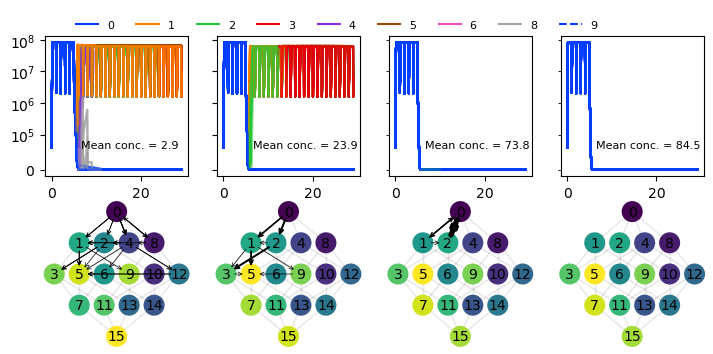

In [144]:
exp = pickle.load(open(e.experiment_info_path,'rb'))
import matplotlib.lines as mlines
# exp = pickle.load(open('./results/results_03072024_0000/experiment_info_03072024_0000.p','rb'))

# p = exp.populations[0]

fig,ax_list = plt.subplots(ncols=4,nrows=2,figsize=(8.5,4))


km_data = stats.km_curve(exp=exp,resistance_outcome=[14,15])
prop_data1 = stats.n_mut_curve(exp=exp,nmut=1)
prop_data2 = stats.n_mut_curve(exp=exp,nmut=2)
prop_data3 = stats.n_mut_curve(exp=exp,nmut=3)

cmap = plt.get_cmap('Accent')

arrowprops = dict(arrowstyle='->', color='black', lw=1.5,mutation_scale=7,shrinkA=6,shrinkB=6)

landscape_options = {'node_size':200,
                    'square':True,'node_label':'base10','arrowprops':arrowprops,
                    'resize_param':0.01,'edge_alpha':0.1,'textsize':10}

cc = plotter.gen_color_cycler()
colors = cc.by_key()['color']
linestyles = cc.by_key()['linestyle']

mean_conc_list = []

for i in range(len(slopes)):

    p = exp.populations[i]
    
    exp_folder = exp.exp_folders[i]

    sim_files = os.listdir(exp_folder)

    ax_indx = len(slopes) - i - 1

    ax = ax_list[0,ax_indx]

    for sim_num in range(n_sims):

        data = stats.get_sim_data(sim_num=sim_num,condition_num=i,exp=exp)

        most_freq = np.argmax(data,axis=1)

        y = np.mean(data,axis=1)

        t = np.arange(len(y))/24

        for g in np.unique(most_freq):

            tt = t[most_freq == g]
            yy = y[most_freq == g]
            ax.plot(tt,yy,linestyles[g],color=colors[g],alpha=0.5,label=g)
        
        ax.set_yscale('symlog',linthresh=10**5)
    
    mean_dc = np.mean(p.drug_curve)
    mean_conc_list.append(mean_dc)
    ax.annotate('Mean conc. = {:.1f}'.format(mean_dc),xy=(0.25,0.2),xycoords='axes fraction',fontsize=8)
    ax_list[0,i].set_yticks([])

    ###########################################################################
    ax = ax_list[1,ax_indx]
    traj_list = []
    for sim_num in range(n_sims):
        
        data = stats.get_sim_data(sim_num=sim_num,condition_num=i,exp=exp)
        trajectory = [0]
        for t in range(len(data[:,0])):
            pop = data[t,:]
            max_gen = np.argmax(pop)
            if max_gen != trajectory[-1]:
                trajectory.append(max_gen)

        if len(trajectory) > 1:
            traj_list.append(trajectory)

    # count the number of each unique trajectory
    
    traj_list = [tuple(traj) for traj in traj_list]

    traj_list_unique = list(set([tuple(traj) for traj in traj_list]))  
    
    traj_list_count = np.zeros((len(traj_list_unique)))
    
    for j,traj in enumerate(traj_list_unique):
        traj_list_count[j] = traj_list.count(traj)

    traj_list_count = 10*(np.array(traj_list_count)/np.sum(traj_list_count))**2

    traj_list_count[traj_list_count < 0.5] = 0.5

    plotter.plot_landscape(p,trajectory_list=traj_list_unique,conc=np.mean(p.drug_curve),ax=ax,
                           colorbar=False,weight_list=traj_list_count,**landscape_options)

    ###########################################################################
    

for ax in ax_list[0,1:]:
    ax.set_yticklabels([])

# for ax in ax_list[0,:]:
    # ax.set_ylim(-10,10**7)

ax = ax_list[0,3]

# get unique legend handles and labels

handles = []
labels = []

for g in [0,1,2,3,4,5,6,8,9]:
    # create dummy artist
    l = mlines.Line2D([], [], linestyle=linestyles[g],color=colors[g], label=g)
    handles.append(l)
    labels.append(g)

fig.legend(handles,labels,loc=[0.1,0.9],ncol=9,fontsize=8,frameon=False)

fig.savefig('../figures/roc_analysis.pdf',bbox_inches='tight')

In [139]:
exp.exp_folders

['results/results_03082024_0000/slope=0.1',
 'results/results_03082024_0000/slope=0.01',
 'results/results_03082024_0000/slope=0.001',
 'results/results_03082024_0000/slope=0.0001']

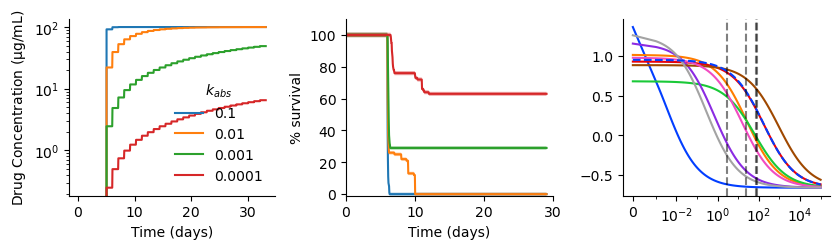

In [148]:
from fears.utils import fitness

fig,ax_list = plt.subplots(ncols=3,figsize=(8.5,2.5))

for i in range(len(slopes)):

    ax = ax_list[0]

    p = e.populations[i]
    t = np.arange(len(p.drug_curve))/24

    ax.plot(t,p.drug_curve,label=slopes[i])

    ax = ax_list[1]

    km_data_t = km_data[list(km_data.keys())[i]]['survival']

    t = np.arange(len(p.drug_curve))/24

    plotter.plot_kaplan_meier(p,km_data_t,mode='survival',ax=ax,t_max=700,n_sims=n_sims)

    ax.set_ylim(-1,110)
    # ax.set_xlim(-1,24)

    xt = np.arange(0,40,10)*24
    ax.set_xticks(xt)
    ax.set_xticklabels(np.arange(0,40,10))

ax_list[0].set_xlabel('Time (days)')
ax_list[1].set_xlabel('Time (days)')

ax_list[0].set_ylabel('Drug Concentration ($\mathrm{\mu g/mL}$)')

ax_list[0].legend(title='$k_{abs}$',frameon=False)

ax_list[0].set_yscale('log')

ax = ax_list[2]

c = np.logspace(-3,5,100)
# append 0 to the left
c = np.append(0,c)

for g in [0,1,2,3,4,5,6,8,9]:
    f = fitness.gen_fitness(p,g,c)
    ax.plot(c,f,linestyles[g],color=colors[g])

ax.set_xscale('symlog',linthresh=10**-3)

ax.set_xticks([0,10**-2,10**0,10**2,10**4])

for c in mean_conc_list:
    ax.axvline(c,ls='--',color='black',alpha=0.5)

for ax in ax_list:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()

fig.savefig('../figures/roc_summary.pdf',bbox_inches='tight')